In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import pickle
import streamlit as st
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV

In [16]:
import numpy as np
import sklearn
import streamlit
import imblearn
import xgboost
import matplotlib

print("NumPy:", np.__version__)
print("Scikit-learn:", sklearn.__version__)
print("Streamlit:", streamlit.__version__)
print("imblearn:", imblearn.__version__)
print("xgboost:", xgboost.__version__)
print("matplotlib:", matplotlib.__version__)

NumPy: 2.0.2
Scikit-learn: 1.6.1
Streamlit: 1.43.2
imblearn: 0.13.0
xgboost: 2.1.4
matplotlib: 3.10.0


In [17]:
# Load dataset
df = pd.read_csv('/content/diabetes.csv')

# Handle categorical features
categorical_cols = ['gender', 'hypertension', 'heart_disease', 'smoking_history']
df[categorical_cols] = df[categorical_cols].astype(str)
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df.shape

(100000, 14)

In [18]:
diabetes_means = df.groupby('diabetes').mean()
print(diabetes_means)

                age        bmi  HbA1c_level  blood_glucose_level  gender_Male  \
diabetes                                                                        
0         40.115187  26.887163     5.396761           132.852470     0.408645   
1         60.946588  31.988382     6.934953           194.094706     0.475176   

          gender_Other  hypertension_1  heart_disease_1  \
diabetes                                                  
0             0.000197        0.058984         0.029235   
1             0.000000        0.245647         0.149059   

          smoking_history_current  smoking_history_ever  \
diabetes                                                  
0                        0.091126              0.038601   
1                        0.111529              0.055529   

          smoking_history_former  smoking_history_never  \
diabetes                                                  
0                       0.084831               0.346984   
1                       

In [19]:
# Features and target
x = df.drop(columns=['diabetes'], axis=1)
y = df['diabetes']

In [20]:
print(x.shape,y.shape)

(100000, 13) (100000,)


In [21]:
#finding missing values
df.isnull().sum()

,0
age,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0
gender_Male,0
gender_Other,0
hypertension_1,0
heart_disease_1,0
smoking_history_current,0


In [22]:
df.value_counts(['diabetes'])

,count
diabetes,
0,91500
1,8500


#our dataset is highly imbalanced so we correct it first

In [23]:
# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy=0.8, random_state=42)  # Prevent over-representation
x_resampled, y_resampled = smote.fit_resample(x, y)

In [24]:
print(x_resampled.shape,y_resampled.shape)

(164700, 13) (164700,)


#standardizing and normalizing data

In [25]:
# Normalize HbA1c separately
x_resampled['HbA1c_level'] = (x_resampled['HbA1c_level'] - x_resampled['HbA1c_level'].min()) / (x_resampled['HbA1c_level'].max() - x_resampled['HbA1c_level'].min())


In [26]:
#standardizing
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_resampled)

#splitting the dataset in test and train data

In [27]:
# Splitting the dataset
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=43)

#hyperparameter tuning

In [28]:
param_grid = {
    'C': [1, 10],
    'gamma': ['scale', 0.1, 1]
}

# Select a smaller dataset for tuning if ur dataset is too large
sample_size = 20000 if len(x_train) > 20000 else len(x_train)
x_sampled, y_sampled = x_train[:sample_size], y_train[:sample_size]

# Optimized RandomizedSearchCV
grid = RandomizedSearchCV(
    svm.SVC(kernel='rbf'),
    param_distributions=param_grid,
    n_iter=5,
    cv=2,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,  # Use all CPU cores
    random_state=42
)

grid.fit(x_sampled, y_sampled)

# Get best parameters
best_params = grid.best_params_
print("✅ Best SVM Parameters:", best_params)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
✅ Best SVM Parameters: {'gamma': 0.1, 'C': 1}


#training and testing

In [29]:
# Train SVM model with best params and non linear kernel
classifier = svm.SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])
classifier.fit(x_train, y_train)

SVC(C=1, gamma=0.1)

normal prediction after hyperparameter tuning

In [30]:
# Model evaluation
y_train_pred = classifier.predict(x_train)
y_test_pred = classifier.predict(x_test)

In [39]:
# Training and Testing Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {100*train_acc:.5f} %")
print(f"Testing Accuracy: {100*test_acc:.5f} %")

Training Accuracy: 93.15877 %
Testing Accuracy: 92.99332 %


using gradient boosting algorithm

In [94]:
# Train XGBoost model
xgb_classifier = XGBClassifier(n_estimators=600, max_depth=7, learning_rate=0.05,subsample=0.8,colsample_bytree=0.6,gamma=1.15)
xgb_classifier.fit(x_train, y_train)

# Evaluating XGBoost accuracy
y_train_pred_xgb = xgb_classifier.predict(x_train)
y_test_pred_xgb = xgb_classifier.predict(x_test)

train_acc_xgb = accuracy_score(y_train, y_train_pred_xgb)
test_acc_xgb = accuracy_score(y_test, y_test_pred_xgb)

print(f"XGBoost Training Accuracy: {100*train_acc_xgb:.5f} %")
print(f"XGBoost Testing Accuracy: {100*test_acc_xgb:.5f} %")

XGBoost Training Accuracy: 97.60474 %
XGBoost Testing Accuracy: 97.34366 %


CHECKING HOW OUR MODEL IS DEPENDENT ON FEATURES THROUGH A VISUAL REPRESENTATION

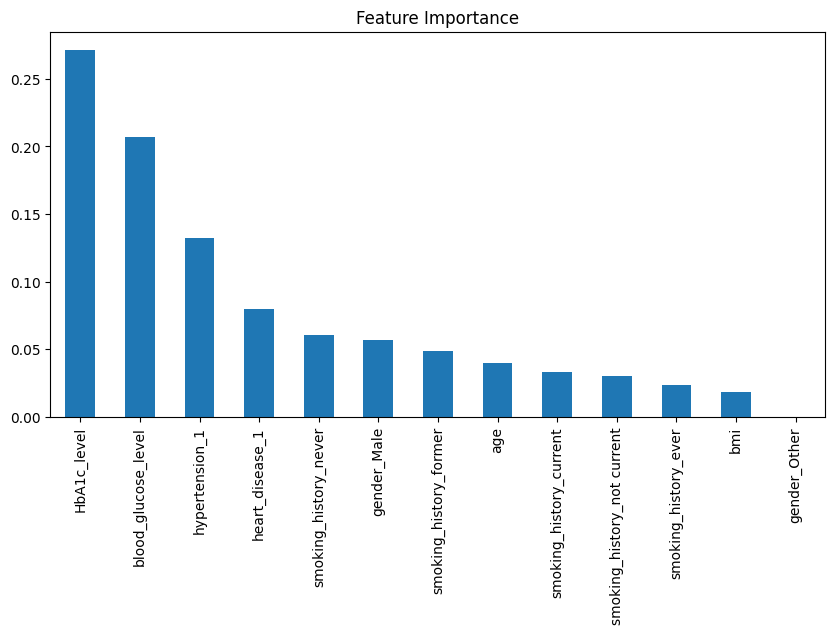

In [95]:
# Check feature importance in XGBoost
feature_importance = pd.Series(xgb_classifier.feature_importances_, index=x.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(10,5), title="Feature Importance")
plt.show()


COMBINING SVM AND XGBoost MODELS

In [96]:
# # Combine SVM and XGBoost
# ensemble_model = VotingClassifier(estimators=[
#     ('svm', classifier),  # Optimized SVM
#     ('xgb', xgb_classifier)  # XGBoost
# ], voting='hard')

# # Train ensemble model
# ensemble_model.fit(x_train, y_train)

# # Evaluate ensemble model
# y_pred_ensemble = ensemble_model.predict(x_test)
# ensemble_acc = accuracy_score(y_test, y_pred_ensemble)

# print(f"Ensemble Model Training Accuracy: {100*train_acc:.5f} %")
# print(f"Ensemble Model Testing Accuracy: {100*ensemble_acc:.5f} %")


In [97]:
# #check feature importance in ensemble
# ensemble_feature_importance = pd.Series(ensemble_model.named_estimators_['xgb'].feature_importances_, index=x.columns)
# ensemble_feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(10,5), title="Ensemble Feature Importance")
# plt.show()

CHECKING OUR MODEL

In [100]:
# Test predictions before saving
sample_inputs = x_test[:100]
sample_preds = classifier.predict(sample_inputs)

print("Sample Predictions:", sample_preds)
print("Actual Labels:", y_test[:100].values)

Sample Predictions: [0 1 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0
 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1
 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1]
Actual Labels: [0 1 0 0 0 1 0 0 0 0 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0
 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1
 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 1]


In [101]:
# Save the trained model and scaler
with open('model.pkl', 'wb') as model_file:
    pickle.dump(classifier, model_file)

with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

In [102]:
#save the features and diabetes_means
with open('features.pkl','wb') as file:
  pickle.dump(x.columns,file)
with open('diabetes_means.pkl','wb') as file:
  pickle.dump(diabetes_means,file)